In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import re
import nltk
import contractions
from plotmat import plot_mat
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from sklearn import svm
from sklearn import datasets, metrics
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix
import umap


from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier

In [2]:
from tempfile import mkdtemp


In [3]:
cachedir = mkdtemp()


In [4]:
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r'http\S+', '', text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    texter = texter.strip()
    texter = contractions.fix(texter)
    texter = re.sub('''[!"#$%&'()*+,/;:-<=>?@[\]^_`{|}~-]''', '', texter)
    texter = texter.lower()
    texter = re.sub(' +', ' ', texter)
    if texter == "":
        texter = ""
    return texter

In [5]:
# Function to get POS Tag
def get_pos_tags(nltkTag):
    firstChar = nltkTag[0]
    if firstChar == 'J':
        return wordnet.ADJ
    if firstChar == 'S':
        return wordnet.ADJ_SAT
    if firstChar == 'V':
        return wordnet.VERB
    if firstChar == 'N':
        return wordnet.NOUN
    if firstChar == 'R':
        return wordnet.ADV
    return wordnet.NOU

In [6]:
#removing stop words
def remove_stopwords(words,stop_words):
    return " ".join([word for word in words if word not in stop_words])

In [7]:
# Whole preprocessing pipeline with removing stop words
def preprocess(sample):
    sample = clean(sample)
    sample = sample.split('.')
    sample = [remove_stopwords(nltk.word_tokenize(sentence), stop_words) for sentence in sample]
    sample = '.'.join(sample)
    return sample

In [8]:
"""
Functions to get the trained SVD and NMF model
"""

def getSVD(n_comp, data):
    SVD = TruncatedSVD(n_components=n_comp, random_state=42)
    SVD.fit(data)
    return SVD

# NMF Non-negative Matrix Factorization
def getNMF(n_comp, data):
    NMFmodel = NMF(n_components=n_comp, init='random', random_state=42)
    NMFmodel.fit(data)
    return NMFmodel

In [9]:
def getScores(y_true, y_pred):

    Homogeneity = homogeneity_score(y_true, y_pred)
    Completeness = completeness_score(y_true, y_pred)
    V_measure = v_measure_score(y_true, y_pred)
    AdjustedRandIndex = adjusted_rand_score(y_true, y_pred)
    Adjusted_mutual_information_score = adjusted_mutual_info_score(y_true, y_pred)
    return {
        'Homogeneity': Homogeneity,
        'Completeness': Completeness,
        'V_measure': V_measure,
        'AdjustedRandIndex': AdjustedRandIndex,
        'Adjusted_mutual_information_score': Adjusted_mutual_information_score
    }

In [10]:
news_data = datasets.fetch_20newsgroups(subset='all', remove=('headers', 'footers'))
labels = np.array(news_data.target)

In [11]:
# Initializations
stop_words = set(stopwords.words('English'))

In [12]:
featurePipeline = Pipeline([
    ('count', CountVectorizer(preprocessor=preprocess, stop_words='english', min_df=3)),
    ('tfidf', TfidfTransformer(smooth_idf=True, use_idf=True))
]).fit(news_data.data)


In [13]:
tfidf_features = featurePipeline.transform(news_data.data)

In [14]:
print(" Data TF-IDF Matrix size: {}".format(tfidf_features.shape))

 Data TF-IDF Matrix size: (18846, 43025)


## Using SVD

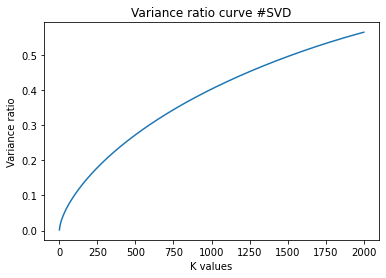

In [15]:
n_components = 2000
SVD = getSVD(n_components, tfidf_features)
variance_ratio = SVD.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(variance_ratio)


plt.plot(np.arange(n_components) + 1, cumulative_variance_ratio)
plt.xlabel("K values")
plt.ylabel("Variance ratio")
plt.title("Variance ratio curve #SVD")
plt.show()

In [16]:
r = [1,2,3,5,10,20,50,100,300, 500, 1000]

SVDScores_Homogeneity = []
SVDScores_Completeness = []
SVDScores_V_measure = []
SVDScores_AdjustedRandIndex = []
SVDScores_Adjusted_mutual_information_score = []


for k in r:
    SVD = getSVD(k, tfidf_features)
    transformed = SVD.transform(tfidf_features)
    kmeans = KMeans(n_clusters=20, random_state=0, max_iter=3000, n_init=50).fit(transformed)
    predictedLabels = kmeans.labels_
    scores = getScores(labels, predictedLabels)
    SVDScores_Homogeneity.append(scores['Homogeneity'])
    SVDScores_Completeness.append(scores['Completeness'])
    SVDScores_V_measure.append(scores['V_measure'])
    SVDScores_AdjustedRandIndex.append(scores['AdjustedRandIndex'])
    SVDScores_Adjusted_mutual_information_score.append(scores['Adjusted_mutual_information_score'])

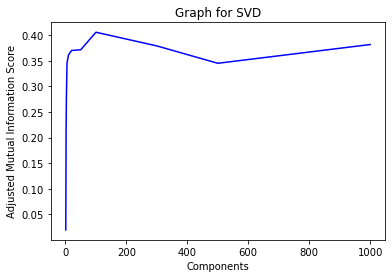

In [17]:
plt.plot(r, SVDScores_Adjusted_mutual_information_score, color='b')
  
plt.xlabel("Components")
plt.ylabel("Adjusted Mutual Information Score")
plt.title("Graph for SVD")
  
plt.show()

In [18]:
r[np.argmax(SVDScores_Adjusted_mutual_information_score)]

100

In [19]:
SVDScores_Adjusted_mutual_information_score[6]

0.37130579202183484

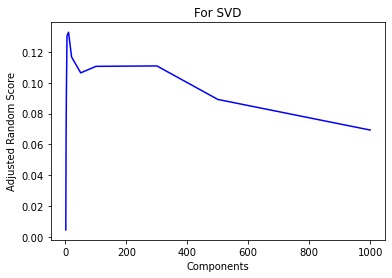

In [20]:
plt.plot(r, SVDScores_AdjustedRandIndex, color='b')
  
plt.xlabel("Components")
plt.ylabel("Adjusted Random Score")
plt.title("For SVD")
  
plt.show()

In [21]:
r[np.argmax(SVDScores_AdjustedRandIndex)]

10

In [22]:
n_components = 100

SVD = getSVD(n_components, tfidf_features)
transformed_features = SVD.transform(tfidf_features)

kmeans = KMeans(n_clusters=20, random_state=0, max_iter=5000, n_init=50).fit(transformed_features)
predicted_labels = kmeans.labels_

scores = getScores(labels, predicted_labels)

In [23]:
scores

{'Homogeneity': 0.3657407059348793,
 'Completeness': 0.4604235535487772,
 'V_measure': 0.4076565490964736,
 'AdjustedRandIndex': 0.1106090872261982,
 'Adjusted_mutual_information_score': 0.405508118880332}

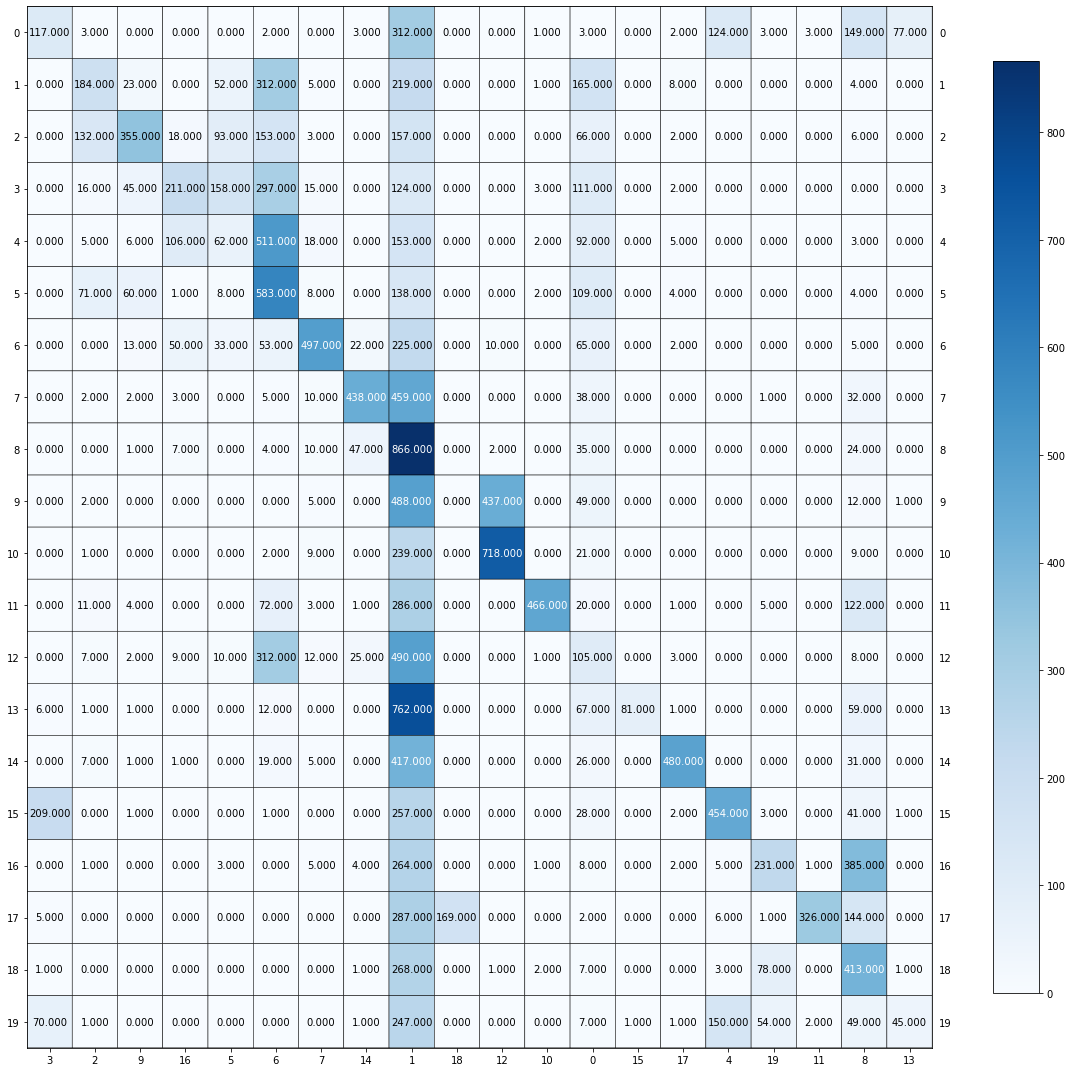

In [24]:
conf_mat = confusion_matrix(labels, predicted_labels)
row, colmn = linear_sum_assignment(conf_mat, maximize=True)
plot_mat(conf_mat[row[:, np.newaxis], colmn], xticklabels=colmn, yticklabels=row, size=(15,15))


## Using NMF

In [28]:
r = [1,5,10,50,100,300]
NMFScores_Homogeneity = []
NMFScores_Completeness = []
NMFScores_V_measure = []
NMFScores_AdjustedRandIndex = []
NMFScores_Adjusted_mutual_information_score = []

for k in r:
    NMFmodel = getNMF(k, tfidf_features)
    transformed = NMFmodel.transform(tfidf_features)
    kmeans = KMeans(n_clusters=20, random_state=0, max_iter=3000, n_init=50).fit(transformed)
    predictedLabels = kmeans.labels_
    scores = getScores(labels, predictedLabels)
    NMFScores_Homogeneity.append(scores['Homogeneity'])
    NMFScores_Completeness.append(scores['Completeness'])
    NMFScores_V_measure.append(scores['V_measure'])
    NMFScores_AdjustedRandIndex.append(scores['AdjustedRandIndex'])
    NMFScores_Adjusted_mutual_information_score.append(scores['Adjusted_mutual_information_score'])


/Users/diplavsrivastava/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Users/diplavsrivastava/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Users/diplavsrivastava/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


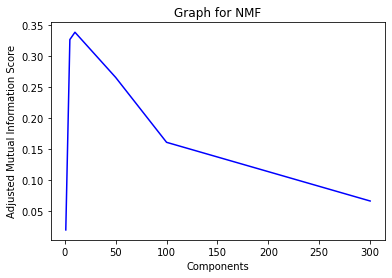

In [29]:
plt.plot(r, NMFScores_Adjusted_mutual_information_score, color='b')
  
plt.xlabel("Components")
plt.ylabel("Adjusted Mutual Information Score")
plt.title("Graph for NMF")
  
plt.show()

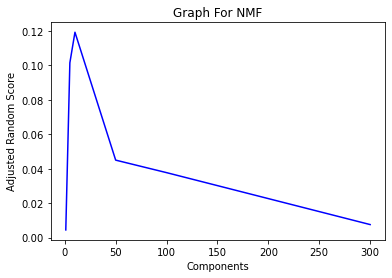

In [30]:
plt.plot(r, NMFScores_AdjustedRandIndex, color='b')
  
plt.xlabel("Components")
plt.ylabel("Adjusted Random Score")
plt.title("Graph For NMF")
  
plt.show()

In [31]:
n_components = 10


NMFmodel = getNMF(n_components, tfidf_features)
transformed_features = NMFmodel.transform(tfidf_features)

kmeans = KMeans(n_clusters=20, random_state=0, max_iter=5000, n_init=50).fit(transformed_features)
predicted_labels_NMF = kmeans.labels_

scores = getScores(labels, predicted_labels_NMF)

In [32]:
scores

{'Homogeneity': 0.32117310066123195,
 'Completeness': 0.36156795498805255,
 'V_measure': 0.34017553285357427,
 'AdjustedRandIndex': 0.11921399244656643,
 'Adjusted_mutual_information_score': 0.33790744391494965}

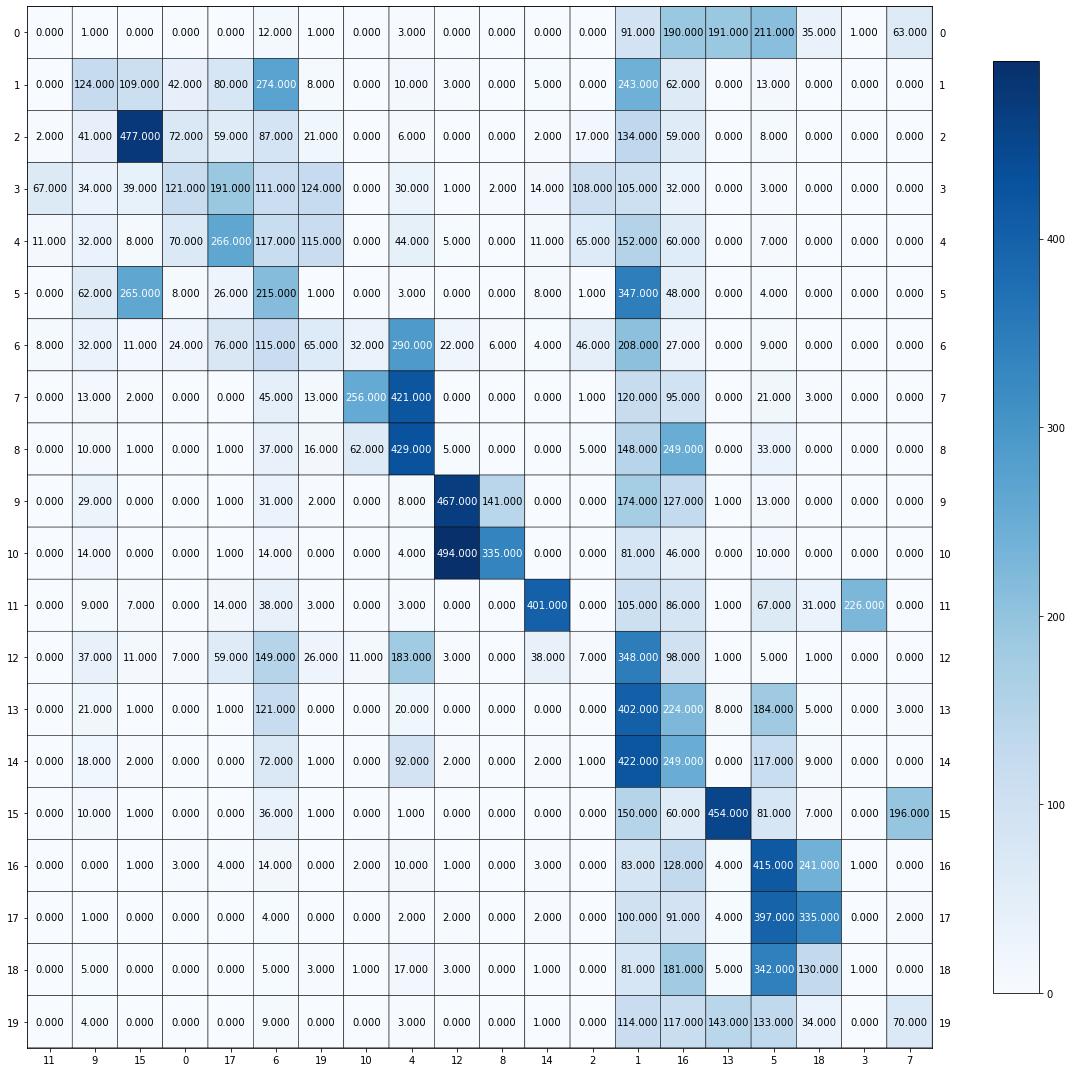

In [33]:
conf_mat = confusion_matrix(labels, predicted_labels_NMF)
row, colmn = linear_sum_assignment(conf_mat, maximize=True)
plot_mat(conf_mat[row[:, np.newaxis], colmn], xticklabels=colmn, yticklabels=row, size=(15,15))


## UMAP

In [42]:
n_comps = [5, 20, 200]

### Euclidean 

In [ ]:
UMAP_Eucl_Homogeneity = []
UMAP_Eucl_Completeness = []
UMAP_Eucl_V_measure = []
UMAP_Eucl_AdjustedRandIndex = []
UMAP_Eucl_Adjusted_mutual_information_score = []
UMAP_Eucl_predlabels = []

for k in n_comps:
    umap_fit = umap.UMAP(n_components=k, random_state=0, metric='euclidean')
    umap_features = umap_fit.fit_transform(tfidf_features)
    kmeans = KMeans(n_clusters=20, random_state=0, max_iter=5000, n_init=50).fit(umap_features)
    predicted_labels = kmeans.labels_
    scores = getScores(labels, predicted_labels)
    UMAP_Eucl_predlabels.append(predicted_labels)
    UMAP_Eucl_Homogeneity.append(scores['Homogeneity'])
    UMAP_Eucl_Completeness.append(scores['Completeness'])
    UMAP_Eucl_V_measure.append(scores['V_measure'])
    UMAP_Eucl_AdjustedRandIndex.append(scores['AdjustedRandIndex'])
    UMAP_Eucl_Adjusted_mutual_information_score.append(scores['Adjusted_mutual_information_score'])


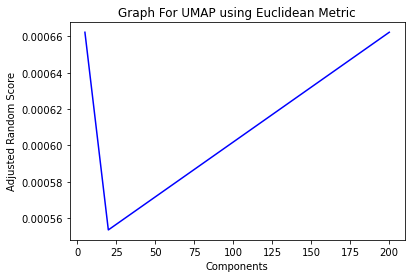

In [43]:
plt.plot(n_comps, UMAP_Eucl_AdjustedRandIndex, color='b')
  
plt.xlabel("Components")
plt.ylabel("Adjusted Random Score")
plt.title("Graph For UMAP using Euclidean Metric")
  
plt.show()

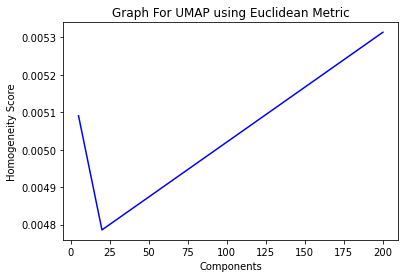

In [44]:
plt.plot(n_comps, UMAP_Eucl_Homogeneity, color='b')
  
plt.xlabel("Components")
plt.ylabel("Homogeneity Score")
plt.title("Graph For UMAP using Euclidean Metric")
  
plt.show()

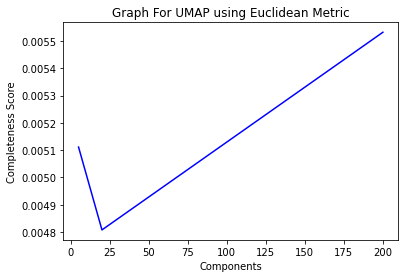

In [45]:
plt.plot(n_comps, UMAP_Eucl_Completeness, color='b')
  
plt.xlabel("Components")
plt.ylabel("Completeness Score")
plt.title("Graph For UMAP using Euclidean Metric")
  
plt.show()

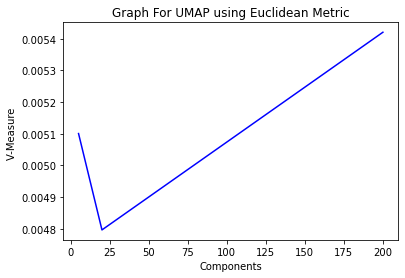

In [46]:
plt.plot(n_comps, UMAP_Eucl_V_measure, color='b')
  
plt.xlabel("Components")
plt.ylabel("V-Measure ")
plt.title("Graph For UMAP using Euclidean Metric")
  
plt.show()

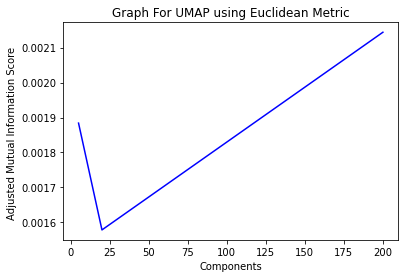

In [47]:
plt.plot(n_comps, UMAP_Eucl_Adjusted_mutual_information_score, color='b')
  
plt.xlabel("Components")
plt.ylabel("Adjusted Mutual Information Score ")
plt.title("Graph For UMAP using Euclidean Metric")
  
plt.show()

#### confusion matric for #comp = 5

In [ ]:
conf_mat = confusion_matrix(labels, UMAP_Eucl_predlabels[0])
row, colmn = linear_sum_assignment(conf_mat, maximize=True)
plot_mat(conf_mat[row[:, np.newaxis], colmn], xticklabels=colmn, yticklabels=row, size=(15,15))

#### confusion matric for #comp = 20

In [ ]:
conf_mat = confusion_matrix(labels, UMAP_Eucl_predlabels[1])
row, colmn = linear_sum_assignment(conf_mat, maximize=True)
plot_mat(conf_mat[row[:, np.newaxis], colmn], xticklabels=colmn, yticklabels=row, size=(15,15))

#### confusion matric for #comp = 200

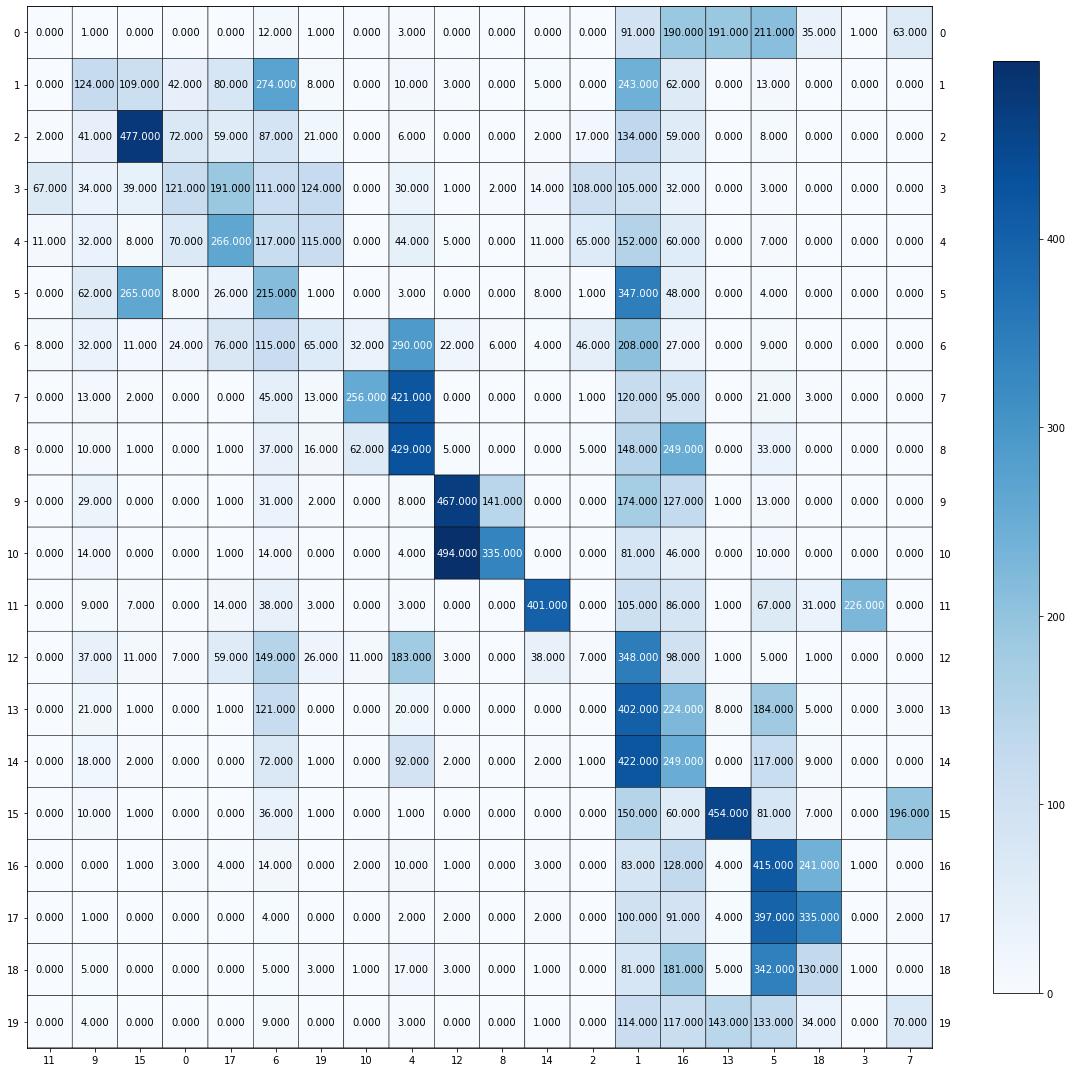

In [48]:
conf_mat = confusion_matrix(labels, UMAP_Eucl_predlabels[2])
row, colmn = linear_sum_assignment(conf_mat, maximize=True)
plot_mat(conf_mat[row[:, np.newaxis], colmn], xticklabels=colmn, yticklabels=row, size=(15,15))

### Cosine Metric

In [49]:
UMAP_Cosine_Homogeneity = []
UMAP_Cosine_Completeness = []
UMAP_Cosine_V_measure = []
UMAP_Cosine_AdjustedRandIndex = []
UMAP_Cosine_Adjusted_mutual_information_score = []
UMAP_Cosine_predlabels = []

for k in n_comps:
    umap_fit = umap.UMAP(n_components=k, random_state=0, metric='cosine')
    umap_features = umap_fit.fit_transform(tfidf_features)
    kmeans = KMeans(n_clusters=20, random_state=0, max_iter=5000, n_init=50).fit(umap_features)
    predicted_labels = kmeans.labels_
    scores = getScores(labels, predicted_labels)
    UMAP_Cosine_predlabels.append(predicted_labels)
    UMAP_Cosine_Homogeneity.append(scores['Homogeneity'])
    UMAP_Cosine_Completeness.append(scores['Completeness'])
    UMAP_Cosine_V_measure.append(scores['V_measure'])
    UMAP_Cosine_AdjustedRandIndex.append(scores['AdjustedRandIndex'])
    UMAP_Cosine_Adjusted_mutual_information_score.append(scores['Adjusted_mutual_information_score'])


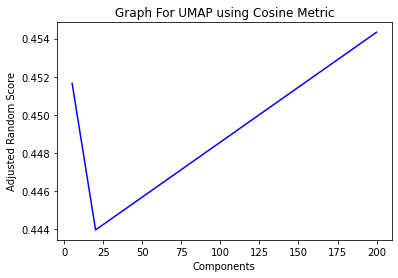

In [51]:
plt.plot(n_comps, UMAP_Cosine_AdjustedRandIndex, color='b')
  
plt.xlabel("Components")
plt.ylabel("Adjusted Random Score")
plt.title("Graph For UMAP using Cosine Metric")
  
plt.show()

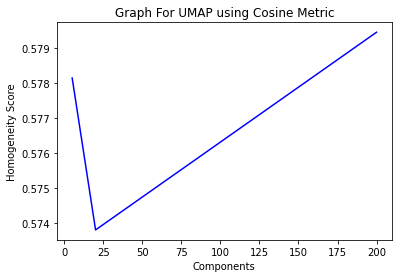

In [52]:
plt.plot(n_comps, UMAP_Cosine_Homogeneity, color='b')
  
plt.xlabel("Components")
plt.ylabel("Homogeneity Score")
plt.title("Graph For UMAP using Cosine Metric")
  
plt.show()

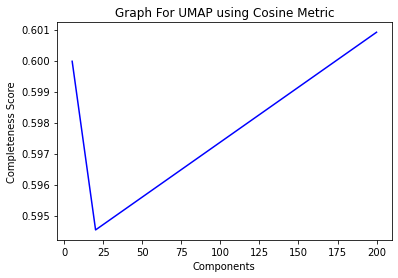

In [53]:
plt.plot(n_comps, UMAP_Cosine_Completeness, color='b')
  
plt.xlabel("Components")
plt.ylabel("Completeness Score")
plt.title("Graph For UMAP using Cosine Metric")
  
plt.show()

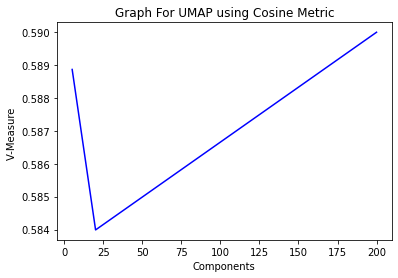

In [54]:
plt.plot(n_comps, UMAP_Cosine_V_measure, color='b')
  
plt.xlabel("Components")
plt.ylabel("V-Measure ")
plt.title("Graph For UMAP using Cosine Metric")
  
plt.show()

In [ ]:
plt.plot(n_comps, UMAP_Cosine_Adjusted_mutual_information_score, color='b')
  
plt.xlabel("Components")
plt.ylabel("Adjusted Mutual Information Score ")
plt.title("Graph For UMAP using Cosine Metric")
  
plt.show()

#### Confusion matrix for # comp = 5

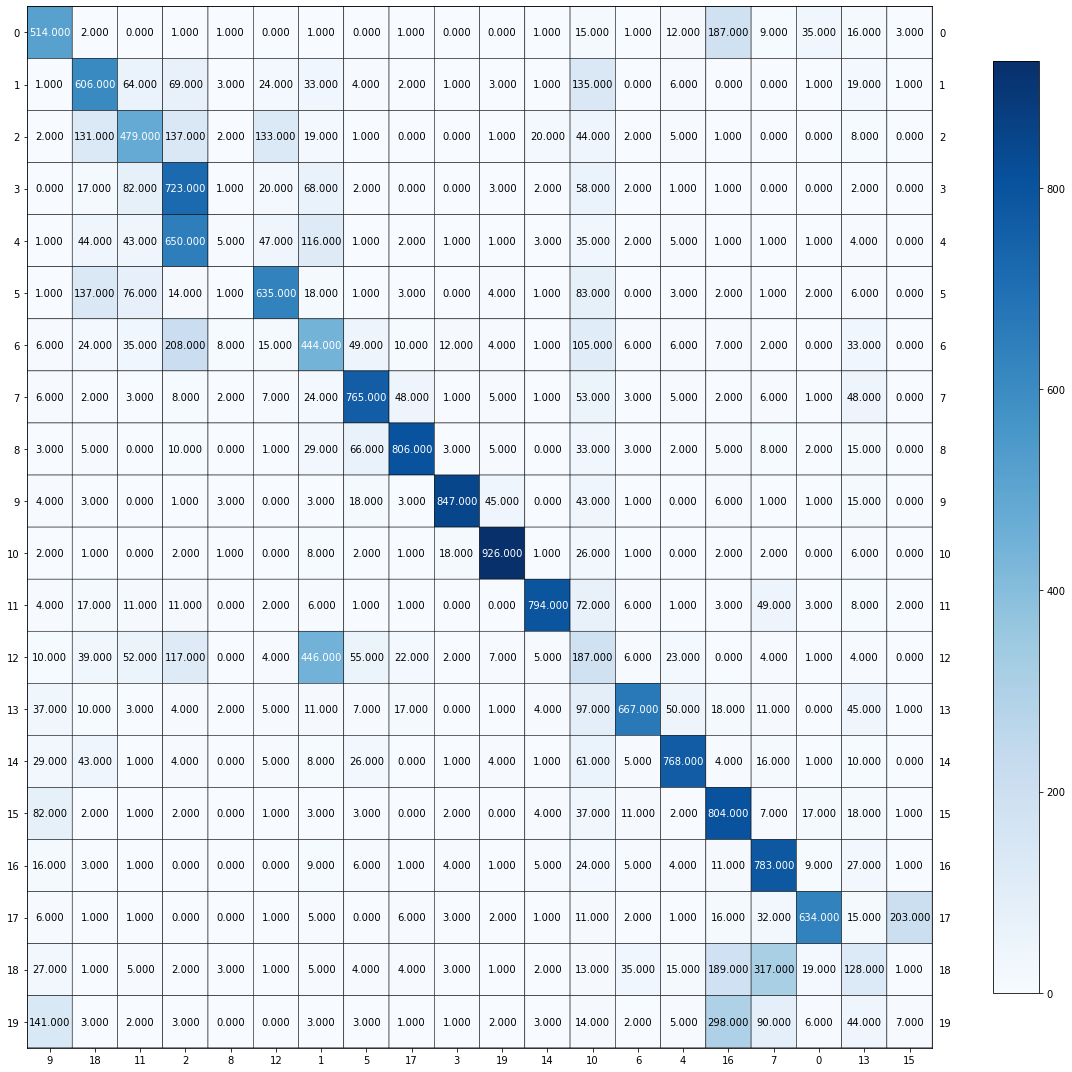

In [55]:
conf_mat = confusion_matrix(labels, UMAP_Cosine_predlabels[0])
row, colmn = linear_sum_assignment(conf_mat, maximize=True)
plot_mat(conf_mat[row[:, np.newaxis], colmn], xticklabels=colmn, yticklabels=row, size=(15,15))

#### Confusion matrix for # comp = 20

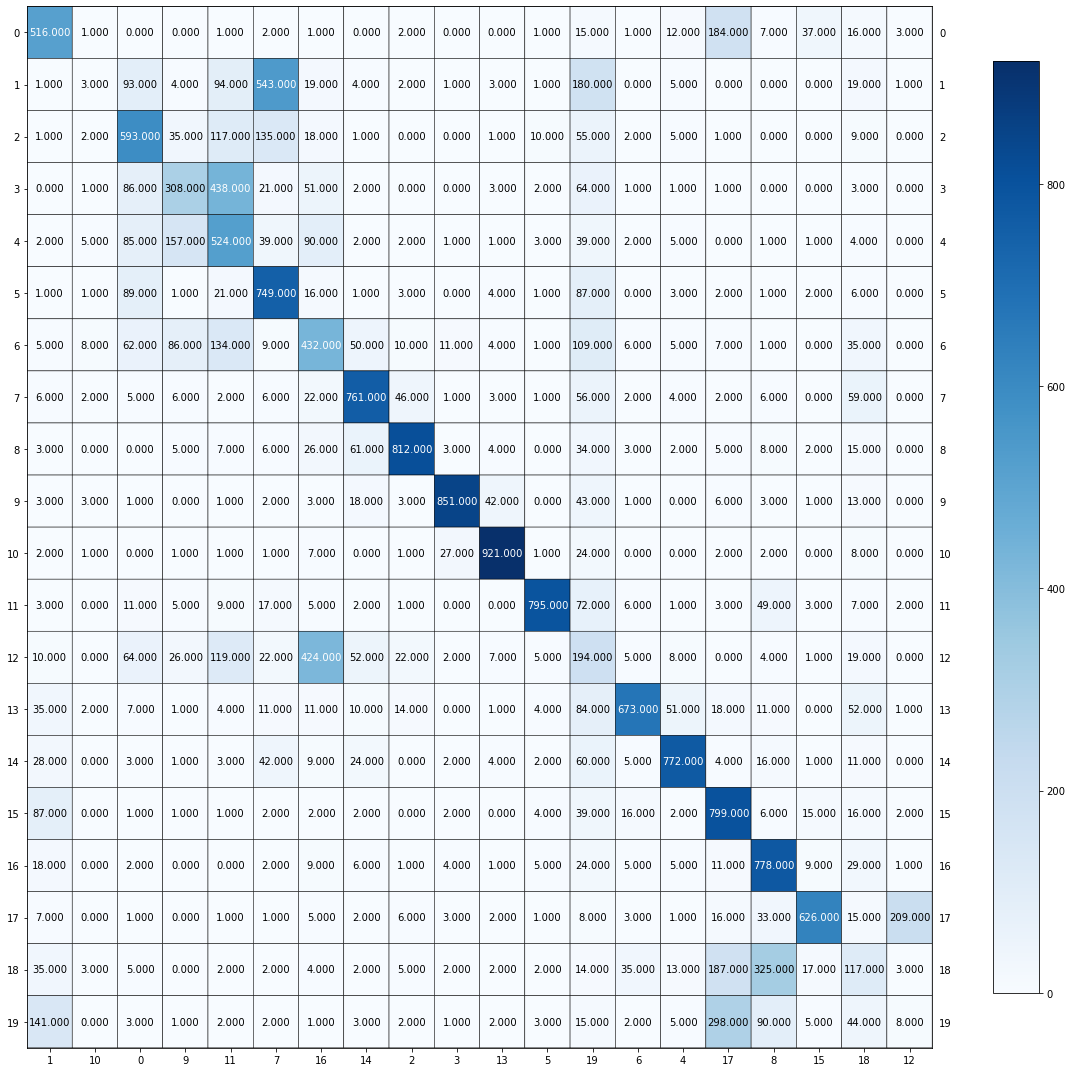

In [56]:
conf_mat = confusion_matrix(labels, UMAP_Cosine_predlabels[1])
row, colmn = linear_sum_assignment(conf_mat, maximize=True)
plot_mat(conf_mat[row[:, np.newaxis], colmn], xticklabels=colmn, yticklabels=row, size=(15,15))

#### Confusion matrix for # comp = 200

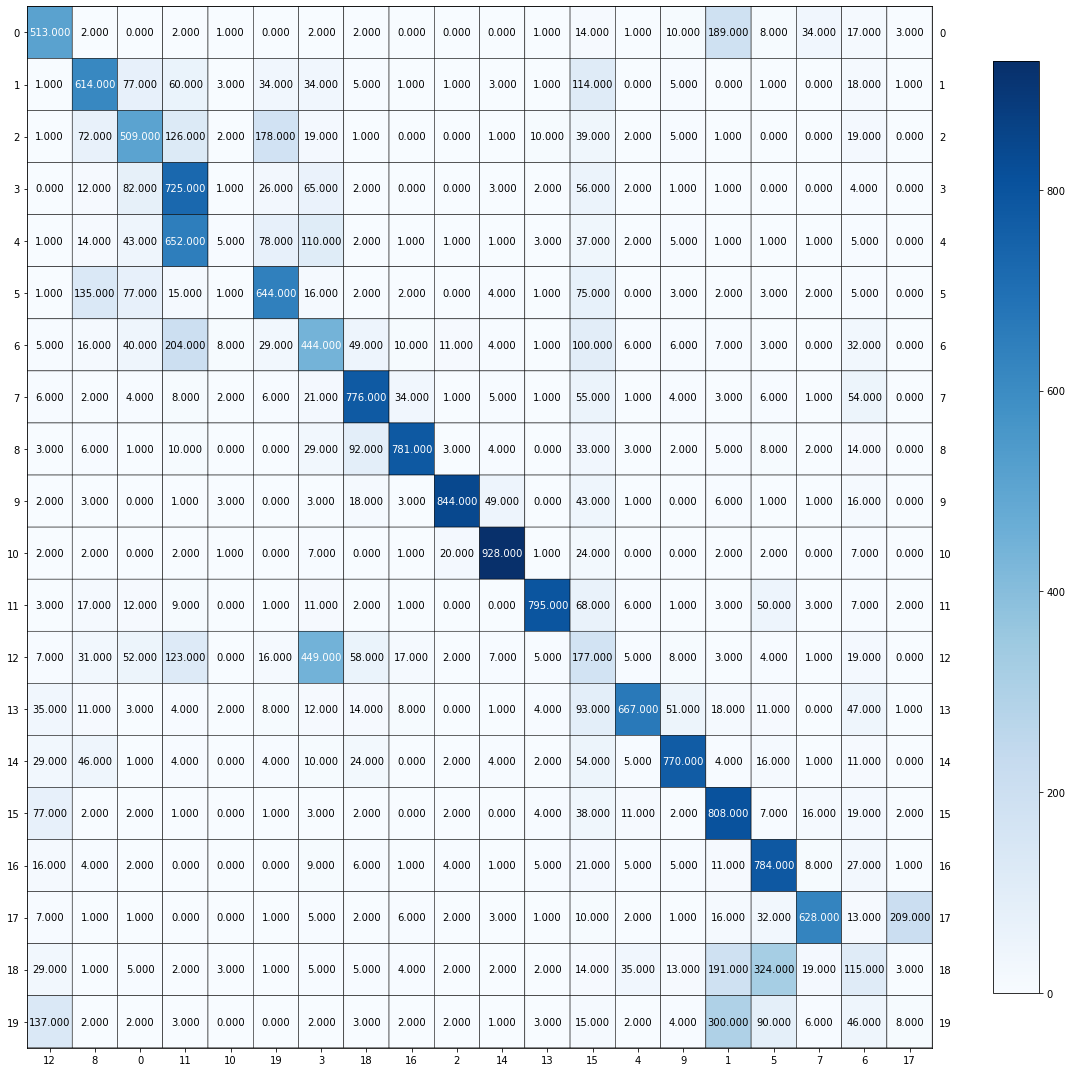

In [57]:
conf_mat = confusion_matrix(labels, UMAP_Cosine_predlabels[2])
row, colmn = linear_sum_assignment(conf_mat, maximize=True)
plot_mat(conf_mat[row[:, np.newaxis], colmn], xticklabels=colmn, yticklabels=row, size=(15,15))

### Agglomerative Clustering